### Simulación test de Stroop con un multilayer perceptron.

Feedforward artificial neural network con backpropagation.

autor: Lukas Valenzuela (lukas-fv)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats



In [2]:
# Primera semilla....
SEED = 42

def set_all_seeds(seed):
    """Fijar todas las semillas"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(SEED)

# Colores y vectores
COLORS = ['rojo', 'verde', 'azul', 'amarillo']
N_COLORS = 4
COLOR_TO_IDX = {c: i for i, c in enumerate(COLORS)} # Diccionario de vectores
IDX_TO_COLOR = {i: c for i, c in enumerate(COLORS)} # Diccionario de vectores

# Arquitectura capa oculta
HIDDEN_SIZE = 16

# Entrenamiento ASIMÉTRICO 
WORD_EPOCHS = 600     # Muchas épocas -> vía FUERTE
COLOR_EPOCHS = 30     # Pocas épocas -> vía débil
COMBINED_EPOCHS = 40  # Refinar
LEARNING_RATE = 0.01 # Para entrenar stochastic gradient descent
BATCH_SIZE = 32 # De entrenamiento

# Experimento
NOISE_LEVEL = 0.30
N_TRIALS = 300

# Device de torch... usaremos CPU ya que no tengo gpu haha
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Configuración cargada")
print(f"Device: {DEVICE}")

Configuración cargada
Device: cpu


In [3]:
#Funciones auxiliares

def encode_stimulus(word, color):
    """Codifica estímulo Stroop con onehot encoding"""
    vec = torch.zeros(N_COLORS * 2)
    vec[COLOR_TO_IDX[word]] = 1.0
    vec[N_COLORS + COLOR_TO_IDX[color]] = 1.0
    return vec


def entropy(probs):
    """Entropía de Shannon - medir incertidumbre."""
    p = probs.clamp(min=1e-10)
    return (-p * torch.log(p)).sum().item()


def create_training_data(n_samples, target_is_word):
    """Crea datos de entrenamiento."""
    X, y = [], []
    for _ in range(n_samples):
        word = np.random.choice(COLORS)
        color = np.random.choice(COLORS)
        X.append(encode_stimulus(word, color))
        if target_is_word:
            y.append(COLOR_TO_IDX[word])
        else:
            y.append(COLOR_TO_IDX[color])
    return torch.stack(X), torch.tensor(y)


#### Acá creamos el modelo

In [4]:
class StroopMLP(nn.Module):
    """
    MLP con dos vías paralelas para simular el efecto Stroop.
    =)
    """
    
    def __init__(self):
        super().__init__()
        
        # Vía de PALABRA: 4 -> 16
        self.word_linear = nn.Linear(N_COLORS, HIDDEN_SIZE)
        
        # Vía de COLOR: 4 -> 16
        self.color_linear = nn.Linear(N_COLORS, HIDDEN_SIZE)
        
        # Integración: 32 -> 32 -> 4
        self.integration1 = nn.Linear(HIDDEN_SIZE * 2, HIDDEN_SIZE * 2)
        self.integration2 = nn.Linear(HIDDEN_SIZE * 2, N_COLORS)
        
        # Inicialización PESOS WEIGHTS 
        self._init_weights()
    
    def _init_weights(self):
        """ Pesos con forma He.... una forma específica de elegir los weights iniciales, para que no crashee el ReLU."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # Separar input
        word_input = x[:, :N_COLORS]
        color_input = x[:, N_COLORS:]
        
        # Procesar vías con ReLU
        word_h = F.relu(self.word_linear(word_input))
        color_h = F.relu(self.color_linear(color_input))
        
        # Concatenar e integrar
        combined = torch.cat([word_h, color_h], dim=1)
        h = F.relu(self.integration1(combined))
        logits = self.integration2(h)
        
        return logits
    
    def predict_proba(self, x):
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            return F.softmax(logits, dim=-1)


# Crear modelo
set_all_seeds(SEED)
model = StroopMLP().to(DEVICE)

print("Modelo creado:")
print(model)
print(f"\nTotal parámetros: {sum(p.numel() for p in model.parameters())}")

Modelo creado:
StroopMLP(
  (word_linear): Linear(in_features=4, out_features=16, bias=True)
  (color_linear): Linear(in_features=4, out_features=16, bias=True)
  (integration1): Linear(in_features=32, out_features=32, bias=True)
  (integration2): Linear(in_features=32, out_features=4, bias=True)
)

Total parámetros: 1348


### Funciones para entrenamiento del modelo

In [5]:
def train_epoch(model, X, y, optimizer, criterion):
    """Entrena una época completa."""
    model.train() # activamos
    
    # Mezclar datos
    perm = torch.randperm(len(X))
    X, y = X[perm], y[perm]
    
    total_loss = 0
    n_batches = 0
    
    for i in range(0, len(X), BATCH_SIZE):
        batch_X = X[i:i+BATCH_SIZE].to(DEVICE)
        batch_y = y[i:i+BATCH_SIZE].to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches


def evaluate_accuracy(model, X, y):
    """Evalúa precisión del modelo."""
    model.eval() # acá desactivamos entrenamiento y vemos precisión
    with torch.no_grad():
        X, y = X.to(DEVICE), y.to(DEVICE)
        probs = model.predict_proba(X)
        preds = probs.argmax(dim=1)
        return (preds == y).float().mean().item() * 100


## Iniciar Entrenamiento para diversas seeds

In [21]:
# =============================================================================
# Acá es lo fundamental. Definimos el modelo con semillas dadas. y corremos el experimento Stroop como tal
# =============================================================================

def train_full_model(seed):
    """
    Entrenar el modelo con el experimento Stroop aplicado y las 3 fases de entrenamiento con una semilla determinada.
    Returna el modelo entrenado.
    """
    set_all_seeds(seed)
    model = StroopMLP().to(DEVICE) 
    criterion = nn.CrossEntropyLoss() # criterio aprendizaje

    # Fase 1 de entrenamiento VIA DE PALABRA FUERTE
    X_word, y_word = create_training_data(2000, target_is_word=True)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE) # 0.01 de learning rate y SGD
    for epoch in range(WORD_EPOCHS):
        loss = train_epoch(model, X_word, y_word, optimizer, criterion)
        # visualizar epochs
        if (epoch + 1) % 100 == 0:
            acc = evaluate_accuracy(model, X_word, y_word)
            print(f'SEED -> {seed} // Fase 1 Época {epoch+1}: Loss={loss:.4f}, Acc={acc:.1f}%')

    # Fase 2 COlOR Via Más Debil!
    X_color, y_color = create_training_data(1000, target_is_word=False)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(COLOR_EPOCHS):
        loss = train_epoch(model, X_color, y_color, optimizer, criterion)
        if (epoch + 1) % 10 == 0:
            acc = evaluate_accuracy(model, X_color, y_color)
            print(f'SEED -> {seed} // Fase 2 Época {epoch+1}: Loss={loss:.4f}, Acc={acc:.1f}%')

    # Fase 3: combinado (refinamiento del test)
    X_comb, y_comb = create_training_data(2000, target_is_word=False)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(COMBINED_EPOCHS):
        loss = train_epoch(model, X_comb, y_comb, optimizer, criterion)
        if (epoch + 1) % 10 == 0:
            acc = evaluate_accuracy(model, X_comb, y_comb)
            print(f'SEED -> {seed} // Fase 3 Época {epoch+1}: Loss={loss:.4f}, Acc={acc:.1f}%')

    return model

def run_stroop_experiment(model, n_trials=N_TRIALS, noise_level=NOISE_LEVEL):
    """
    Correr el experimento como tal...
    Returna df para cada trial con condición, precisión (accuracy), y RT como (entropía)
    noise_level definido como 0.3
    """
    model.eval() # se desactiva modo training, y se activa modo eval
    results = [] # para guardar resultados

    # Trials congruentes
    for _ in range(n_trials):
        color = np.random.choice(COLORS)
        word = color # palabra = color

        stim = encode_stimulus(word, color)
        noise = torch.randn_like(stim) * noise_level # ruido gaussiano
        noisy_stim = (stim + noise).to(DEVICE) # vector más ruido

        probs = model.predict_proba(noisy_stim)[0]
        pred_idx = probs.argmax().item()
        correct_idx = COLOR_TO_IDX[color]

        results.append({
            'condition': 'congruent',
            'correct': int(pred_idx == correct_idx),
            'entropy': entropy(probs)
        })

    # Trials Incongruentes
    for _ in range(n_trials):
        color = np.random.choice(COLORS)
        word = np.random.choice([c for c in COLORS if c != color]) # palabra != color

        stim = encode_stimulus(word, color)
        noise = torch.randn_like(stim) * noise_level # ruido gaussiano
        noisy_stim = (stim + noise).to(DEVICE) # vector más ruido

        probs = model.predict_proba(noisy_stim)[0]
        pred_idx = probs.argmax().item()
        correct_idx = COLOR_TO_IDX[color]

        results.append({
            'condition': 'incongruent',
            'correct': int(pred_idx == correct_idx),
            'entropy': entropy(probs)
        })

    return pd.DataFrame(results)

def summarize_experiment(df):
    """
    Calcular métricas... precision y rt entropia... 
    para df de trials
    """

    cong =  df[df['condition'] == 'congruent']
    incong = df[df['condition'] == 'incongruent']

    acc_cong = cong['correct'].mean() * 100
    acc_incong = incong['correct'].mean() * 100
    ent_cong = cong['entropy'].mean()
    ent_incong = incong['entropy'].mean()

    return {
        'acc_cong': acc_cong,
        'acc_incong': acc_incong,
        'ent_cong': ent_cong,
        'ent_incong': ent_incong,
        'acc_diff': acc_incong - acc_cong, # Incong - Cong (deberia ser negativo)
        'ent_diff': ent_incong - ent_cong, # Incong - Cong (deberia ser positivo)
    }

print('Funciones ready...')

Funciones ready...


## Análisis MULTI-SEEDS ...

por ejemplo... N seeds equivaldrían a N sujetos

en este caso haremos 10 modelos, y comparamos si se repiten los efectos

In [9]:
SEEDS = [42, 77, 15, 32, 95, 55, 69, 24, 13, 83]
model_summaries = []

for seed in SEEDS:
    print('\n')
    print('==='*60)
    print(f' Entrenando MLP con SEED {seed}')
    print('==='*60)


    model = train_full_model(seed)
    df_trials = run_stroop_experiment(model)
    summary = summarize_experiment(df_trials)
    summary['seed'] = seed
    model_summaries.append(summary)

df_models = pd.DataFrame(model_summaries)

print('\n')
print('Resumen por seed:')
print(df_models[['seed', 'acc_cong', 'acc_incong', 'ent_cong', 'ent_incong']])



 Entrenando MLP con SEED 42
SEED -> 42 // Fase 1 Época 100: Loss=0.0017, Acc=100.0%
SEED -> 42 // Fase 1 Época 200: Loss=0.0007, Acc=100.0%
SEED -> 42 // Fase 1 Época 300: Loss=0.0004, Acc=100.0%
SEED -> 42 // Fase 1 Época 400: Loss=0.0003, Acc=100.0%
SEED -> 42 // Fase 1 Época 500: Loss=0.0002, Acc=100.0%
SEED -> 42 // Fase 1 Época 600: Loss=0.0002, Acc=100.0%
SEED -> 42 // Fase 2 Época 10: Loss=0.1311, Acc=100.0%
SEED -> 42 // Fase 2 Época 20: Loss=0.0301, Acc=100.0%
SEED -> 42 // Fase 2 Época 30: Loss=0.0148, Acc=100.0%
SEED -> 42 // Fase 3 Época 10: Loss=0.0069, Acc=100.0%
SEED -> 42 // Fase 3 Época 20: Loss=0.0044, Acc=100.0%
SEED -> 42 // Fase 3 Época 30: Loss=0.0031, Acc=100.0%
SEED -> 42 // Fase 3 Época 40: Loss=0.0024, Acc=100.0%


 Entrenando MLP con SEED 77
SEED -> 77 // Fase 1 Época 100: Loss=0.0013, Acc=100.0%
SEED -> 77 // Fase 1 Época 200: Loss=0.0005, Acc=100.0%
SEED -> 77 // Fase 1 Época 300: Loss=0.0003, Acc=100.0%
SEED -> 77 // Fase 1 Época 400: Loss=0.0002, Acc=10

In [10]:
df_models

,acc_cong,acc_incong,ent_cong,ent_incong,acc_diff,ent_diff,seed
0,99.333333,92.666667,0.083006,0.194280,-6.666667,0.111275,42
1,96.333333,94.000000,0.159921,0.190815,-2.333333,0.030895,77
2,98.333333,93.333333,0.077009,0.214982,-5.000000,0.137973,15
3,98.000000,94.666667,0.091226,0.126173,-3.333333,0.034947,32
4,98.000000,93.000000,0.146469,0.211122,-5.000000,0.064653,95
5,96.666667,92.666667,0.083023,0.195668,-4.000000,0.112645,55
6,97.000000,93.333333,0.110658,0.191353,-3.666667,0.080695,69
7,96.000000,94.000000,0.133804,0.189991,-2.000000,0.056187,24
8,94.666667,90.666667,0.152468,0.216578,-4.000000,0.064110,13
9,97.666667,94.333333,0.146859,0.183085,-3.333333,0.036226,83


## Resultados
Tests pareados para observar si se cumplen hipótesis

#### H1: Precisión será mayor en trials congruentes que incongruentes  

#### H2: "Tiempo de reaccion" operacionalizado en entropía, será mayor en incongruentes que incongruentes

In [11]:
# Creamos arrays con los valores

acc_cong_vals = df_models['acc_cong'].values  # Precisión trials congruentes
acc_incong_vals = df_models['acc_incong'].values # Precisión trials incongruentes

ent_cong_vals = df_models['ent_cong'].values # "tiempo de reacción" entropia trials congruentes
ent_incong_vals = df_models['ent_incong'].values # "tiempo de reacción" entropia trials incongruentes

# Deltas
diff_acc = acc_cong_vals - acc_incong_vals # Se espera que sea número positivo... indicando Cong > Incong (H1)
diff_ent = ent_incong_vals - ent_cong_vals # También deberia ser positivo, indicando entropia Incong > Cong (H2)

In [27]:
diff_acc.mean()

np.float64(3.933333333333337)

In [24]:
diff_ent.mean()*100

np.float64(7.2960587963646875)

#### Supuesto normalidad para ttest pareado... shapiro wilk > 0.05

In [13]:
# Solo para ser más riguroso... correr Shapiro-Wilk para supuesto de normalidad con N=10 no tan adecuado. en este caso equivale a testear normalidad de residuos..., es un modelo simplificado asi que con diferencias esta ok.

w_acc, p_shapiro_acc = stats.shapiro(diff_acc)
w_ent, p_shapiro_ent = stats.shapiro(diff_ent)

print('Shapiro Acc:', w_acc, p_shapiro_acc)
print('Shapiro Ent:', w_ent, p_shapiro_ent)



Shapiro Acc: 0.9532242759586597 0.7067063061274695
Shapiro Ent: 0.9137697817944653 0.3079020072643044


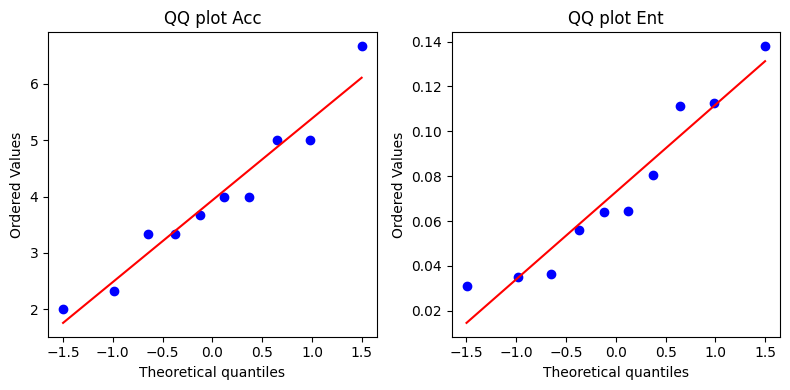

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

# QQ para ΔAcc
stats.probplot(diff_acc, dist="norm", plot=axes[0])
axes[0].set_title("QQ plot Acc")

# QQ para ΔEnt
stats.probplot(diff_ent, dist="norm", plot=axes[1])
axes[1].set_title("QQ plot Ent")

plt.tight_layout()
plt.show()


### Ttest pareado

**Se esperan las dos hipótesis direccionadas propuestas**

**H1**: Precisión (accuracy) sea mayor en Congruente que en Incongruente (Cong > Incong)

**H2**: "Tiempo de reacción"(entropía) sea mayor en Incongruente que Congruente (Incong > Cong)

In [15]:
# Ttest pareado

# H1 Cong > Incong (por eso párametro greater)
t_acc, p_acc = stats.ttest_rel(acc_cong_vals, acc_incong_vals, alternative='greater') 

# H2 Incong > Cong (idem)
t_ent, p_ent = stats.ttest_rel(ent_incong_vals, ent_cong_vals, alternative='greater')


print(f'H1 t-value {t_acc}, p_val {p_acc}')
print(f'H2 t-value {t_ent}, p_val {p_ent}')


H1 t-value 9.091879295794005, p_val 3.928348653237904e-06
H2 t-value 6.235479632593445, p_val 7.612677920081917e-05


#### Se cumplen ambas hipótesis

In [19]:
df_models[['acc_cong', 'acc_incong', 'ent_cong', 'ent_incong']].mean()

acc_cong      97.200000
acc_incong    93.266667
ent_cong       0.118444
ent_incong     0.191405
dtype: float64

In [20]:
df_models[['acc_cong', 'acc_incong', 'ent_cong', 'ent_incong']].std(ddof=1)

acc_cong      1.344399
acc_incong    1.141798
ent_cong      0.032890
ent_incong    0.025672
dtype: float64

In [17]:
def cohen_d_paired(x, y):
    diff = x - y
    return diff.mean() / diff.std(ddof=1)

d_acc = cohen_d_paired(acc_cong_vals, acc_incong_vals) # cong - incong
d_ent = cohen_d_paired(ent_incong_vals, ent_cong_vals) # incong - cong

print('d Acc', d_acc)
print('d Ent', d_ent)


d Acc 2.8751046786036807
d Ent 1.9718317942585182



Se cumplen hipótesis propuestas y modelo funciona.